In [159]:
from glob import glob
import pandas as pd
from Bio import SeqIO
from paretoset import paretoset
import numpy as np
import datetime

ADD GETORF INFO

In [160]:
files_dict = {filename.split('/')[-1].split('.')[0]: filename for filename in glob('results/orf_x_ref/*.csv')}
dfs = {key: pd.read_csv(file_path) for key, file_path in files_dict.items()}
getorf = '/home/tobamo/analize/project-tobamo/analysis/whole_orf/results/getorf_output_find1_min_360_max_3510.fasta'

In [161]:
with open(getorf, "r") as file:
    data = [record.description for record in SeqIO.parse(file, "fasta")]

getorf = pd.DataFrame({
    'orf_name': [item.split()[0].replace('=', '_') for item in data],
    'orf_start': [int(item.split('[')[1].split(' - ')[0]) for item in data],
    'orf_end': [int(item.split(' - ')[1].split(']')[0]) for item in data],
    'orientation': ['REVERSE' if "(REVERSE SENSE)" in item else 'FORWARD' for item in data]
})

In [162]:
for key, df in dfs.items():
    merged = df.merge(getorf, how='left', on='orf_name')
    # merged.to_csv(f'results/orf_x_ref_getorf_info/{key}_getorf_info.csv', index=False)
    dfs[key] = merged

FILTER AND MERGE

In [163]:
# define pareto function for cp and mp (abs_diff - min)
def calculate_pareto_set(group):
    group['on_pareto_front'] = paretoset(group[['identity_score', 'N/aln_len', 'gap_ratio']], sense=["max", "max", "min"])
    return group

In [164]:
for key, df in dfs.items():
    pareto = df.groupby('contig_name', group_keys=False).apply(calculate_pareto_set)
    dfs[key] = pareto

FIGURE OUT LIMITS FROM REFERENCE FILES

In [165]:
f_dict = {filename.split('/')[-1].split('.')[0]: filename for filename in glob('results/reference_limits/*.csv')}
ref_dfs = {key: pd.read_csv(file_path) for key, file_path in f_dict.items()}

In [166]:
final_tables = {}
metrics = {'identity_score': 'Identity Score', 'gap_ratio': 'Gap Ratio', 'N/aln_len': 'N/aln_len'}

# Iterate through each metric
for metric, label in metrics.items():
    max_scores_list = []
    min_scores_list = []
    
    # Iterate through each DataFrame
    for key, df in ref_dfs.items():
        max_scores_list.append(df.groupby('pair_type')[metric].max())
        min_scores_list.append(df.groupby('pair_type')[metric].min())

    max_scores_df = pd.concat(max_scores_list, axis=1, keys=ref_dfs.keys())
    min_scores_df = pd.concat(min_scores_list, axis=1, keys=ref_dfs.keys())

    final_tables[label] = pd.concat({
        f'Max {label}': max_scores_df.transpose(),
        f'Min {label}': min_scores_df.transpose()
    }, axis=1)

# Combine all final tables into a single table
final_table_combined = pd.concat(final_tables, axis=1)
final_table_combined

Identity Score                                   \
                 Max Identity Score               Min Identity Score   
pair_type                 og-tobamo tobamo-tobamo          og-tobamo   
rdrp_orf2_pareto           0.420635      1.000000           0.317734   
rdrp_orf1_pareto           0.353877      0.999105           0.283412   
cp_pareto                  0.407767      1.000000           0.184049   
mp_pareto                  0.321267      0.996212           0.202532   

                                   Gap Ratio                              \
                               Max Gap Ratio               Min Gap Ratio   
pair_type        tobamo-tobamo     og-tobamo tobamo-tobamo     og-tobamo   
rdrp_orf2_pareto      0.514019      0.035865      0.018367      0.003205   
rdrp_orf1_pareto      0.385379      0.050708      0.025907      0.028613   
cp_pareto             0.333333      0.079602      0.032680      0.021277   
mp_pareto             0.250951      0.061856      0.057047      0.028070   

                                   N/aln_len                              \
                               Max N/aln_len               Min N/aln_len   
pair_type        tobamo-tobamo     og-tobamo tobamo-tobamo     og-tobamo   
rdrp_orf2_pareto           0.0      0.996795           1.0      0.766600   
rdrp_orf1_pareto           0.0      0.839300           1.0      0.644068   
cp_pareto                  0.0      0.867021           1.0      0.453744   
mp_pareto                  0.0      0.899614           1.0      0.661932   

                                
                                
pair_type        tobamo-tobamo  
rdrp_orf2_pareto      0.841897  
rdrp_orf1_pareto      0.670753  
cp_pareto             0.746544  
mp_pareto             0.684366

In [185]:
# final_table_combined.to_excel('reference_limits_table.xlsx')

FILTER DFS

In [171]:
filtered_dfs = {}

for key, df in dfs.items():
    name = key.replace('orf_x_ref', 'pareto')

    id_score_lim = final_table_combined.loc[(f'{name}'), ('Identity Score', 'Min Identity Score', 'tobamo-tobamo')]
    naln_len_lim = final_table_combined.loc[(f'{name}'), ('N/aln_len', 'Min N/aln_len', 'tobamo-tobamo')]

    def filter_rows(dataframe):
        filtered_df = dataframe[(dataframe['identity_score'] >= id_score_lim) & (dataframe['N/aln_len'] >= naln_len_lim)]
        return filtered_df

    filtered_df = filter_rows(df)
    filtered_dfs[key] = filtered_df

edit col names, add prefixes

In [174]:
num = 0.5

for key, df in filtered_dfs.items():
    name = key.replace('_orf_x_ref', '')
    df = df.drop(labels='SRR', axis=1)
    rnm = df[df['on_pareto_front'] == True].copy()
    rnm[f'idscore>{num}'] = np.where(rnm['identity_score'] > num, True, False)
    rnm.rename(columns={col: f'{name}_{col}' for col in rnm.columns if col not in ['contig_name']}, inplace=True)
    filtered_dfs[key] = rnm

In [180]:
# merge dataframes
megamerge = filtered_dfs['rdrp_orf1_orf_x_ref'].merge(filtered_dfs['rdrp_orf2_orf_x_ref'], on='contig_name', how='outer').merge(filtered_dfs['mp_orf_x_ref'], on='contig_name', how='outer').merge(filtered_dfs['cp_orf_x_ref'], on='contig_name', how='outer')

In [181]:
megamerge['SRR'] = megamerge["contig_name"].str.extract(r"_([A-Za-z0-9]+)$")

In [182]:
# set first cols
first_columns = ['SRR', 'contig_name',  f'rdrp_orf1_idscore>{num}',  f'rdrp_orf2_idscore>{num}', f'mp_idscore>{num}', f'cp_idscore>{num}']

# Reorder the columns
mega = megamerge[first_columns + [col for col in megamerge.columns if col not in first_columns]]

In [184]:
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
mega.to_csv(f'results/orf_x_ref_megamerge_{current_date}_filtered.csv')

In [196]:
mega.SRR.nunique()

84

In [197]:
mega.contig_name.nunique()

438

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
df = mega[['rdrp_orf1_idscore>0.5', 'rdrp_orf2_idscore>0.5', 'mp_idscore>0.5', 'cp_idscore>0.5']]

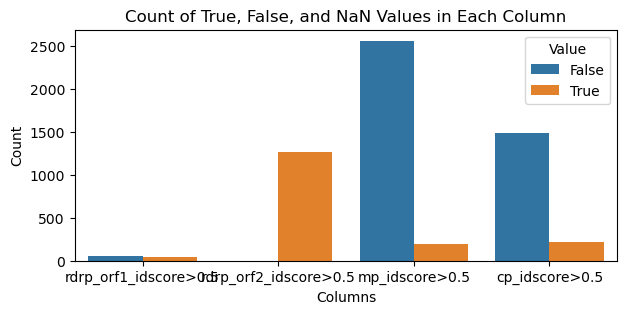

In [207]:
# Stacking the DataFrame
stacked_df = df.stack().reset_index()
stacked_df.columns = ['index', 'column', 'value']

# Specifying the order of x-axis labels
order = ['rdrp_orf1_idscore>0.5', 'rdrp_orf2_idscore>0.5', 'mp_idscore>0.5', 'cp_idscore>0.5']

# Plotting the count of each value in each column with sorted x-axis labels
plt.figure(figsize=(7,3))
sns.countplot(data=stacked_df, x='column', hue='value', order=order)
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Count of True, False, and NaN Values in Each Column')
plt.legend(title='Value', loc='upper right')
plt.show()